# d phi visualization

This notebook includes mds and d phi computation and visualization.

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.markers as markers
from matplotlib.lines import Line2D
from mpl_toolkits import mplot3d
import seaborn as sns; sns.set()
import numpy as np
import math
import copy
import yaml
import sys
import colorsys as csys

import sklearn
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
# from mpl_toolkits import mplot3d
from points_registration import points_registration

In [83]:
filenames = ['0112_1000', '0112_1031', '0112_1153', '0112_1305' ,'0112_1328']
#filenames = ['0112_1000']
guid_path = [0x6a7d, 0x6a4b, 0x6a20, 0x6a46, 0x6755]
guid_len = [18.95, 22.49, 10.06, 10.2]
stick_l = 0.82
r_tag_points = np.array([[-0.65, 0.0],[0.12, 0.13]])

color_met ={}
cnt = 0
for name in filenames:
    rgb = csys.hsv_to_rgb(float(cnt)/len(filenames), 1, 1)
    color_met[name] = rgb
    cnt+=1

#patch_1 = Line2D([0], [0], marker='.', color='w', label='Traj P1', markerfacecolor=color_met['0112_1031'], markersize=35)
#patch_2 = Line2D([0], [0], marker='.', color='w', label='Traj P2', markerfacecolor=color_met['0112_1153'], markersize=35)
#patch_3 = Line2D([0], [0], marker='.', color='w', label='Traj P3', markerfacecolor=color_met['0112_1328'], markersize=35)
patches = []

def ax_init_d(ax, color):
    # ax.set_facecolor((1.0, 1.0, 1.0))
    # axes[0].axis('equal')
    ax.set_aspect('auto')
    #ax.set_xbound(lower=-10, upper=5)
    #ax.set_ybound(lower=-2, upper=65)
    #ax.set_xticks(ticks=ax.get_xticks())
    #ax.set_xticklabels(-1*ax.get_xticks())
    ax.tick_params(axis='x',labelsize=25)
    ax.tick_params(axis='y',labelsize=25, color=color)
    #ax.legend(handles=patches, fontsize=30)
    #ax.set_xlabel('Timestamp (sec)', fontsize=20)
    ax.set_ylabel('d (meter)', fontsize=25, color=color)
    ax.grid(color=[0.3, 0.3, 0.3], linestyle='-', linewidth=2)
    return ax
def ax_init_phi(ax, color):
    # ax.set_facecolor((1.0, 1.0, 1.0))
    # axes[0].axis('equal')
    ax.set_aspect('auto')
    #ax.set_xbound(lower=-10, upper=5)
    #ax.set_ybound(lower=-2, upper=65)
    #ax.set_xticks(ticks=ax.get_xticks())
    #ax.set_xticklabels(-1*ax.get_xticks())
    ax.tick_params(axis='x',labelsize=25)
    ax.tick_params(axis='y',labelsize=25, color=color)
    #ax.legend(handles=patches, fontsize=30)
    ax.set_ylabel('phi (degree)', fontsize=25, color=color)
    ax.set_xlabel('Timestamp (sec)', fontsize=25)
    ax.grid(color=[0.3, 0.3, 0.3], linestyle='-', linewidth=2)
    return ax

In [92]:
def check_flip(out, left=True):
    # we assume the robot is always on the left of the lane

    rb = out[-4]
    rf = out[-3]
    mid = rb+rf/2
    
    lb = out[-2]
    lf = out[-1]

    '''
    if lf[1]==lb[1]:
        if (lf[0]-lf[1])*(rf[1]-lf[1]) < 0:
            return True if left else False
        if (lf[0]-lf[1])*(rb[1]-lb[1]) < 0:
            return True if left else False
        return False if left else True

    if lf[0]!=lb[0]:
        slope,c = np.polyfit([lb[0],lf[0]],[lb[1],lf[1]],1)
        pbx = 1.*(-1*c + rb[1])/slope
        pfx = 1.*(-1*c + rf[1])/slope
    else:
        pbx = lb[0]
        pfx = lf[0]

    if (lf[1]-lb[1])*(rf[0]-pfx) > 0 :
        return True if left else False
    if (lf[1]-lb[1])*(rb[0]-pbx) > 0 :
        return True if left else False
    # if lf[1]==lb[1] and 

    return False if left else True
    '''
    
    mid_b = lb-mid
    mid_f = lf-mid
    
    direction = np.cross(mid_b, mid_f)
    
    if direction > 0:
        return not left # don't flip
    else:
        return left # flip
            

('New file: ', 'data/jackal_ranges_0112_1000.yaml')


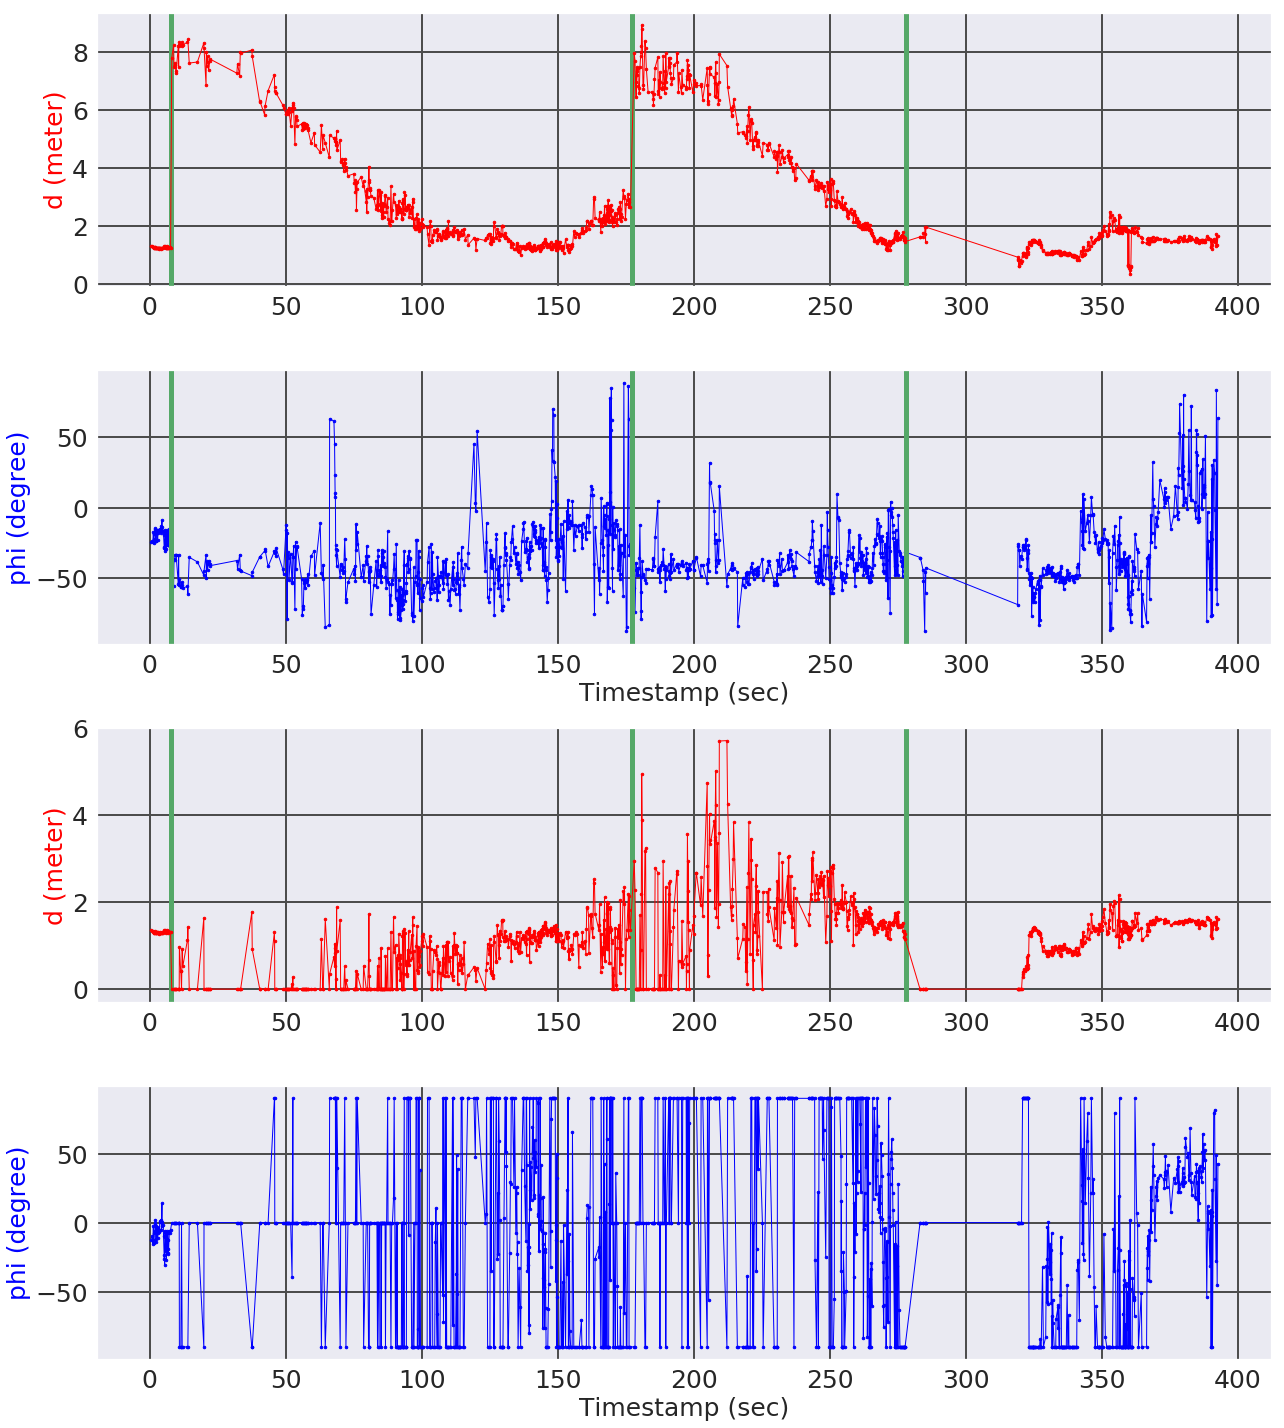

('New file: ', 'data/jackal_ranges_0112_1031.yaml')


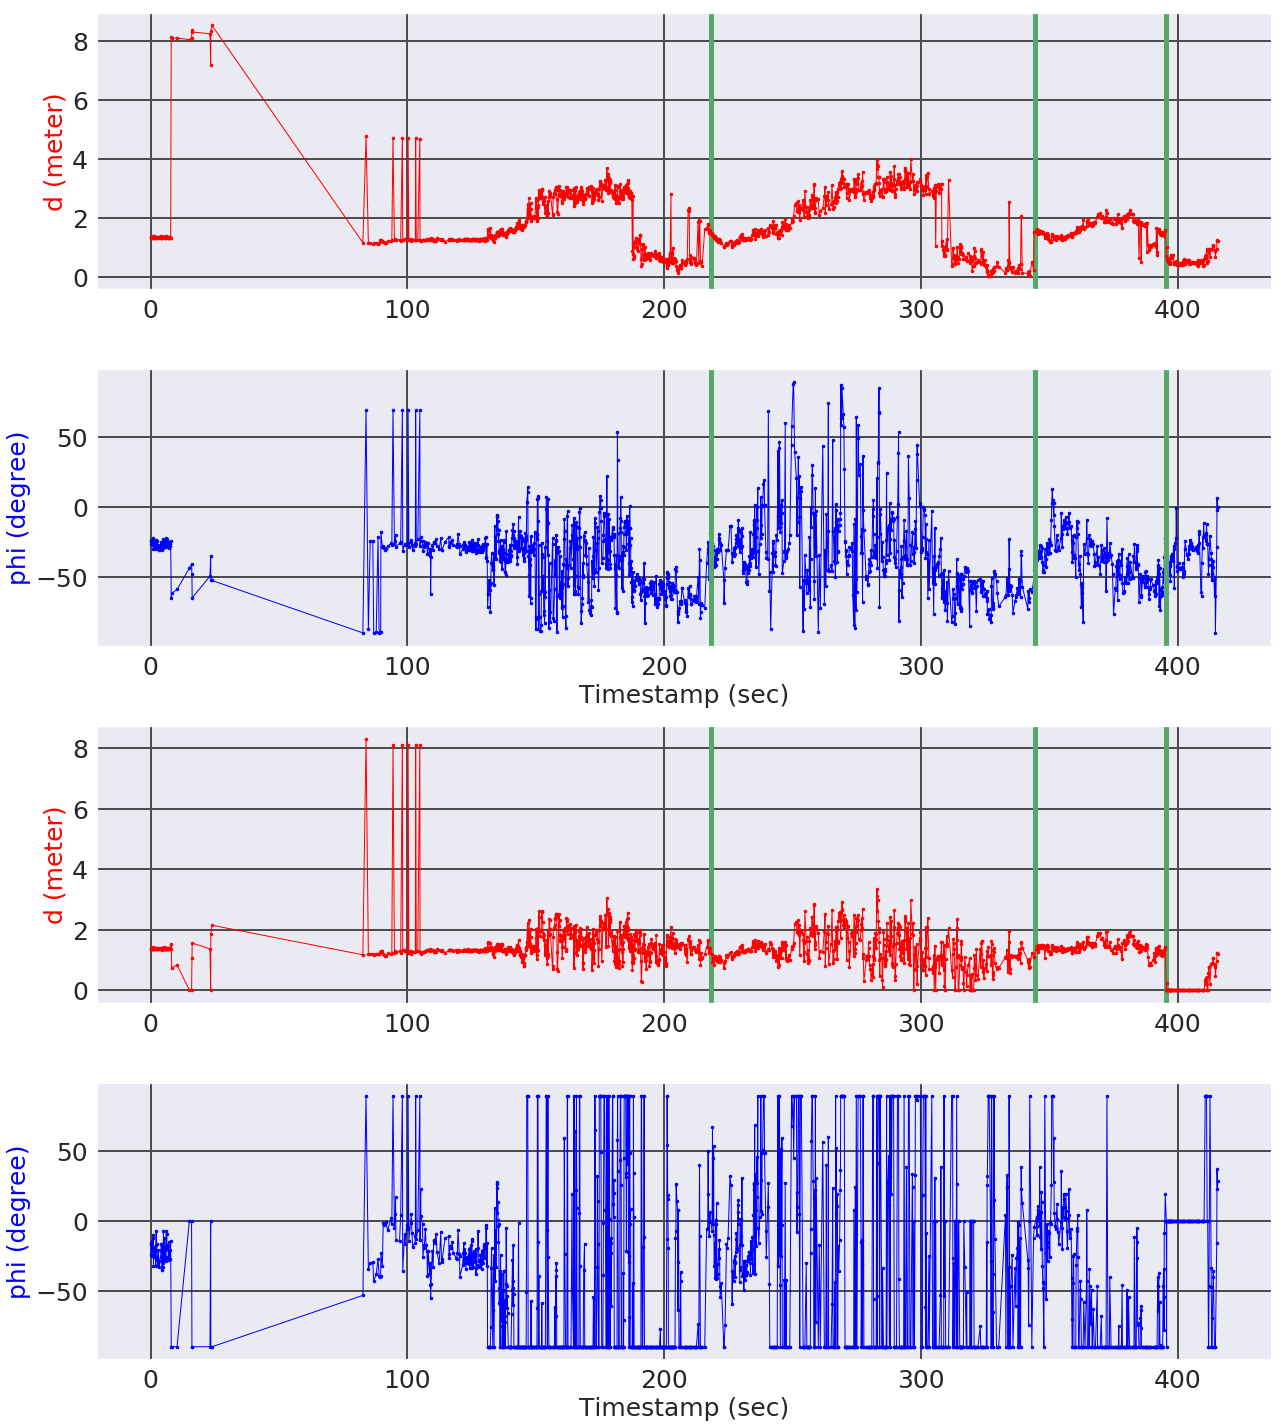

('New file: ', 'data/jackal_ranges_0112_1153.yaml')


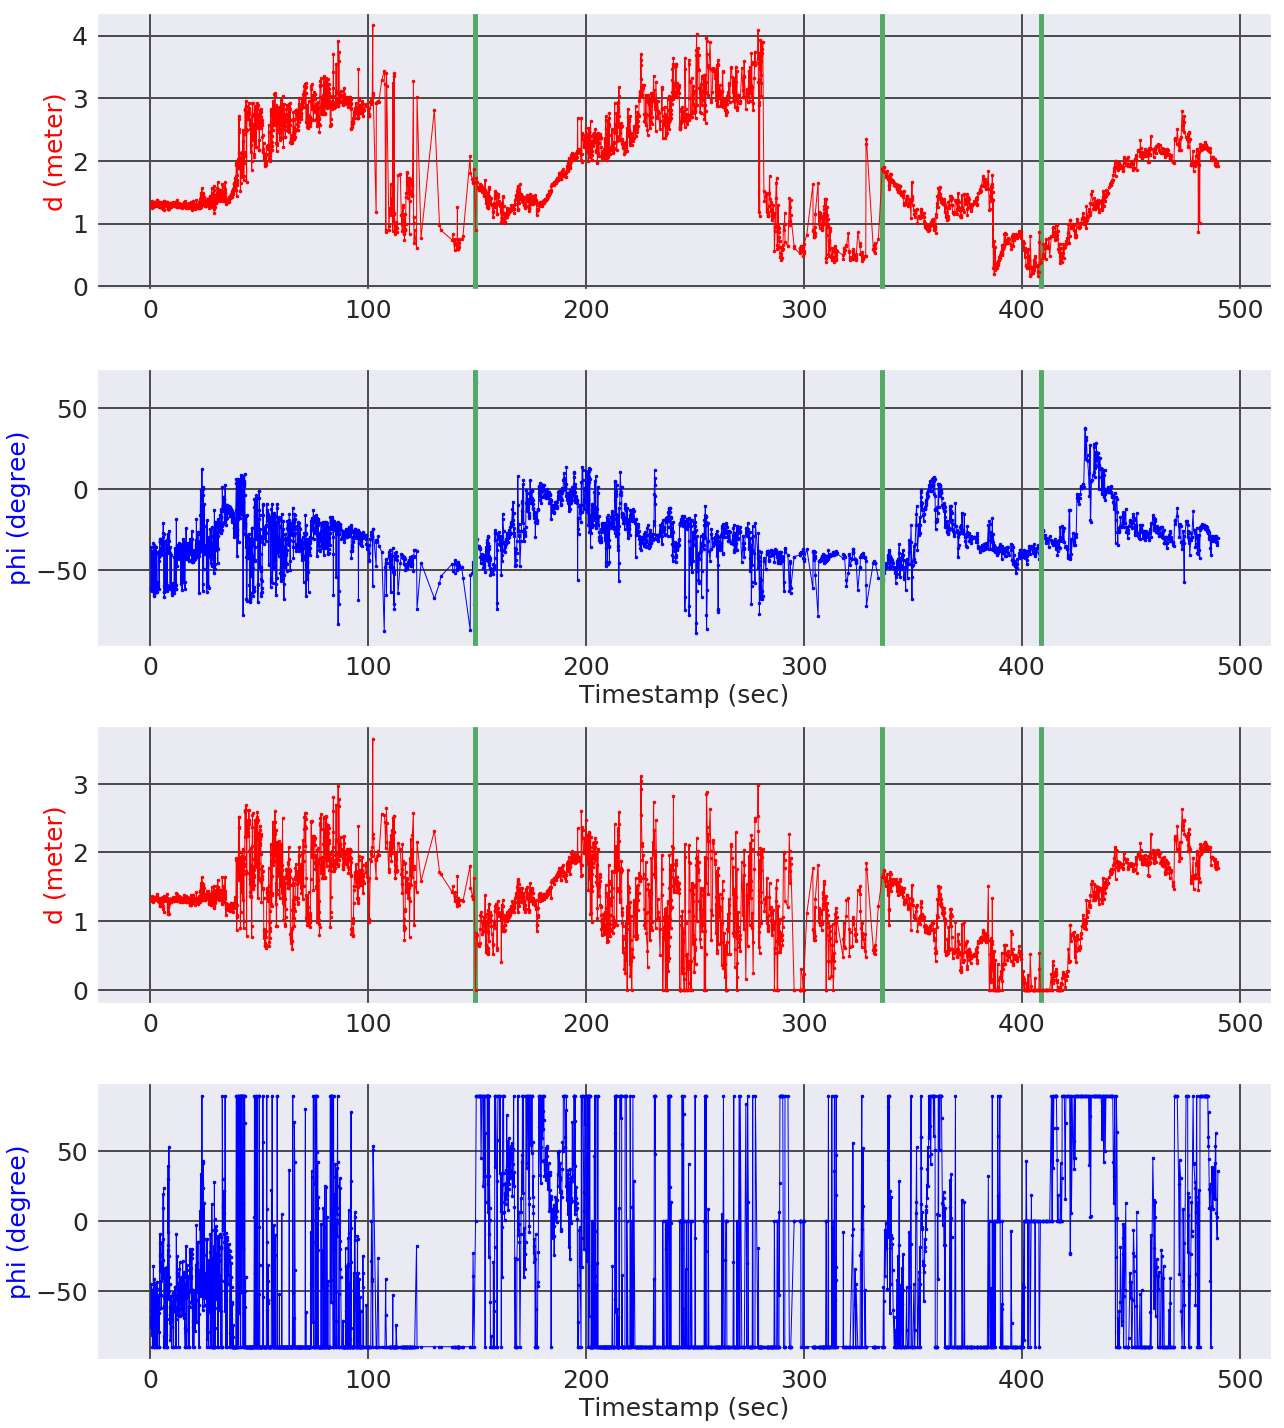

('New file: ', 'data/jackal_ranges_0112_1305.yaml')


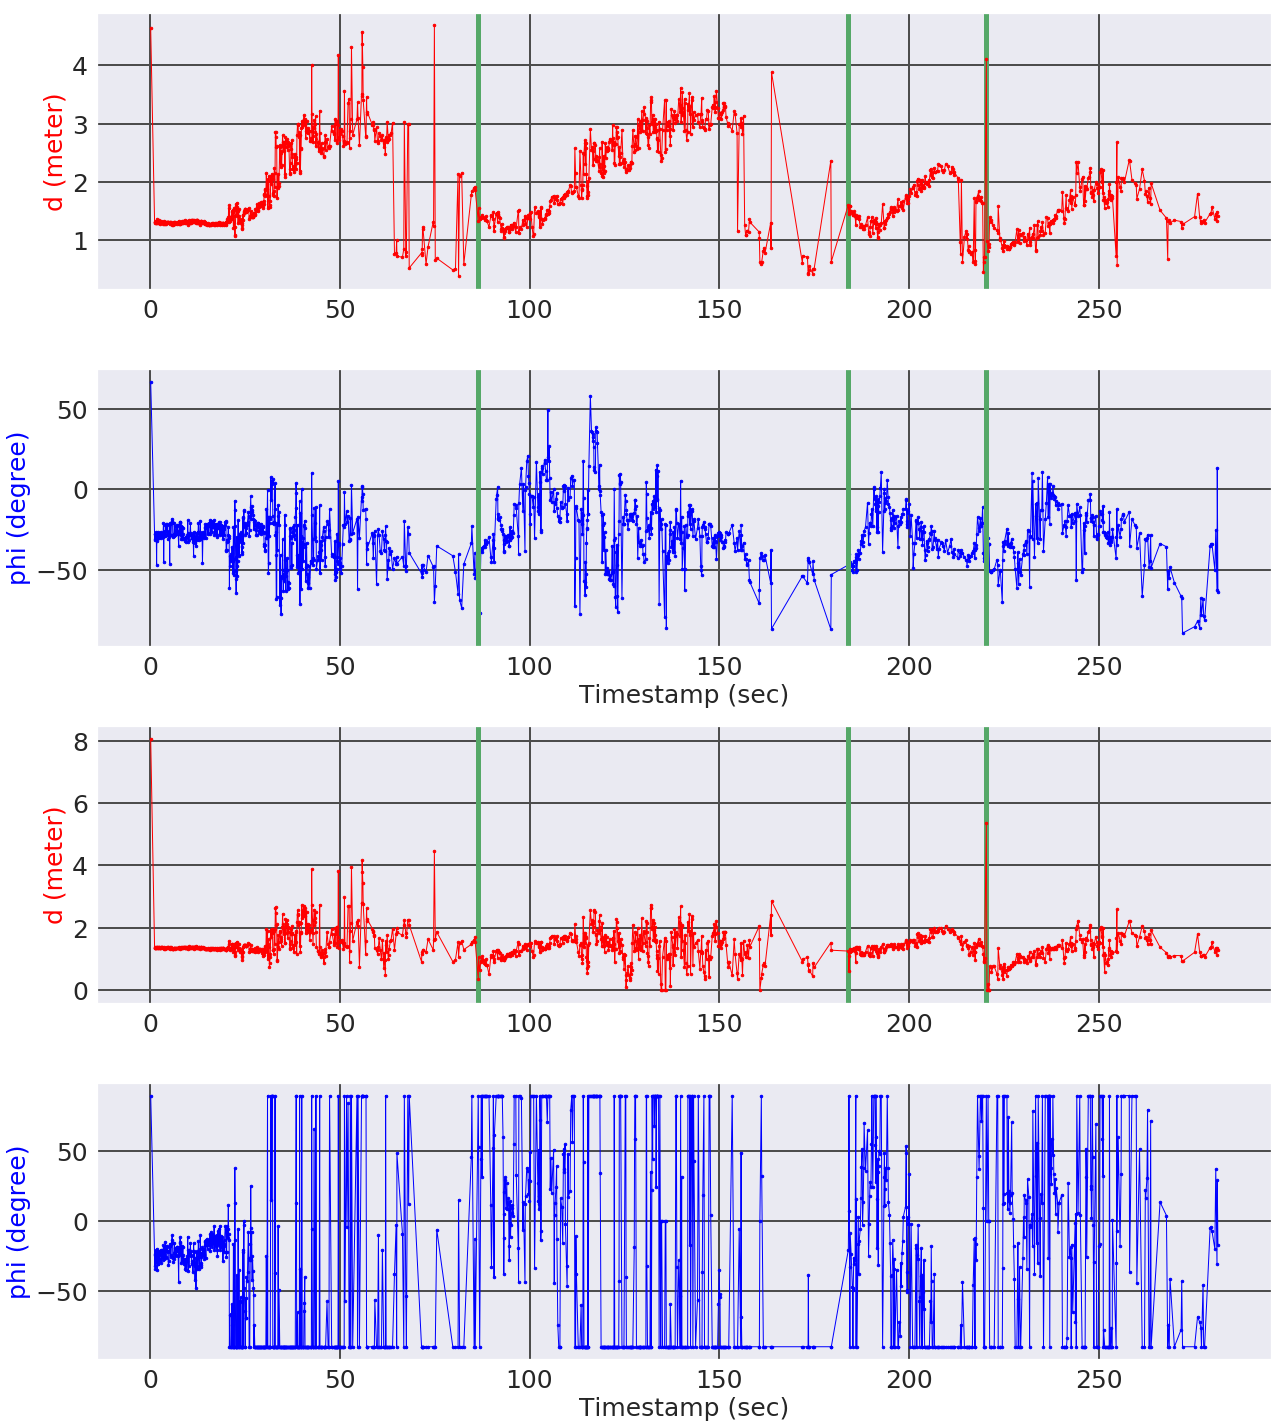

('New file: ', 'data/jackal_ranges_0112_1328.yaml')


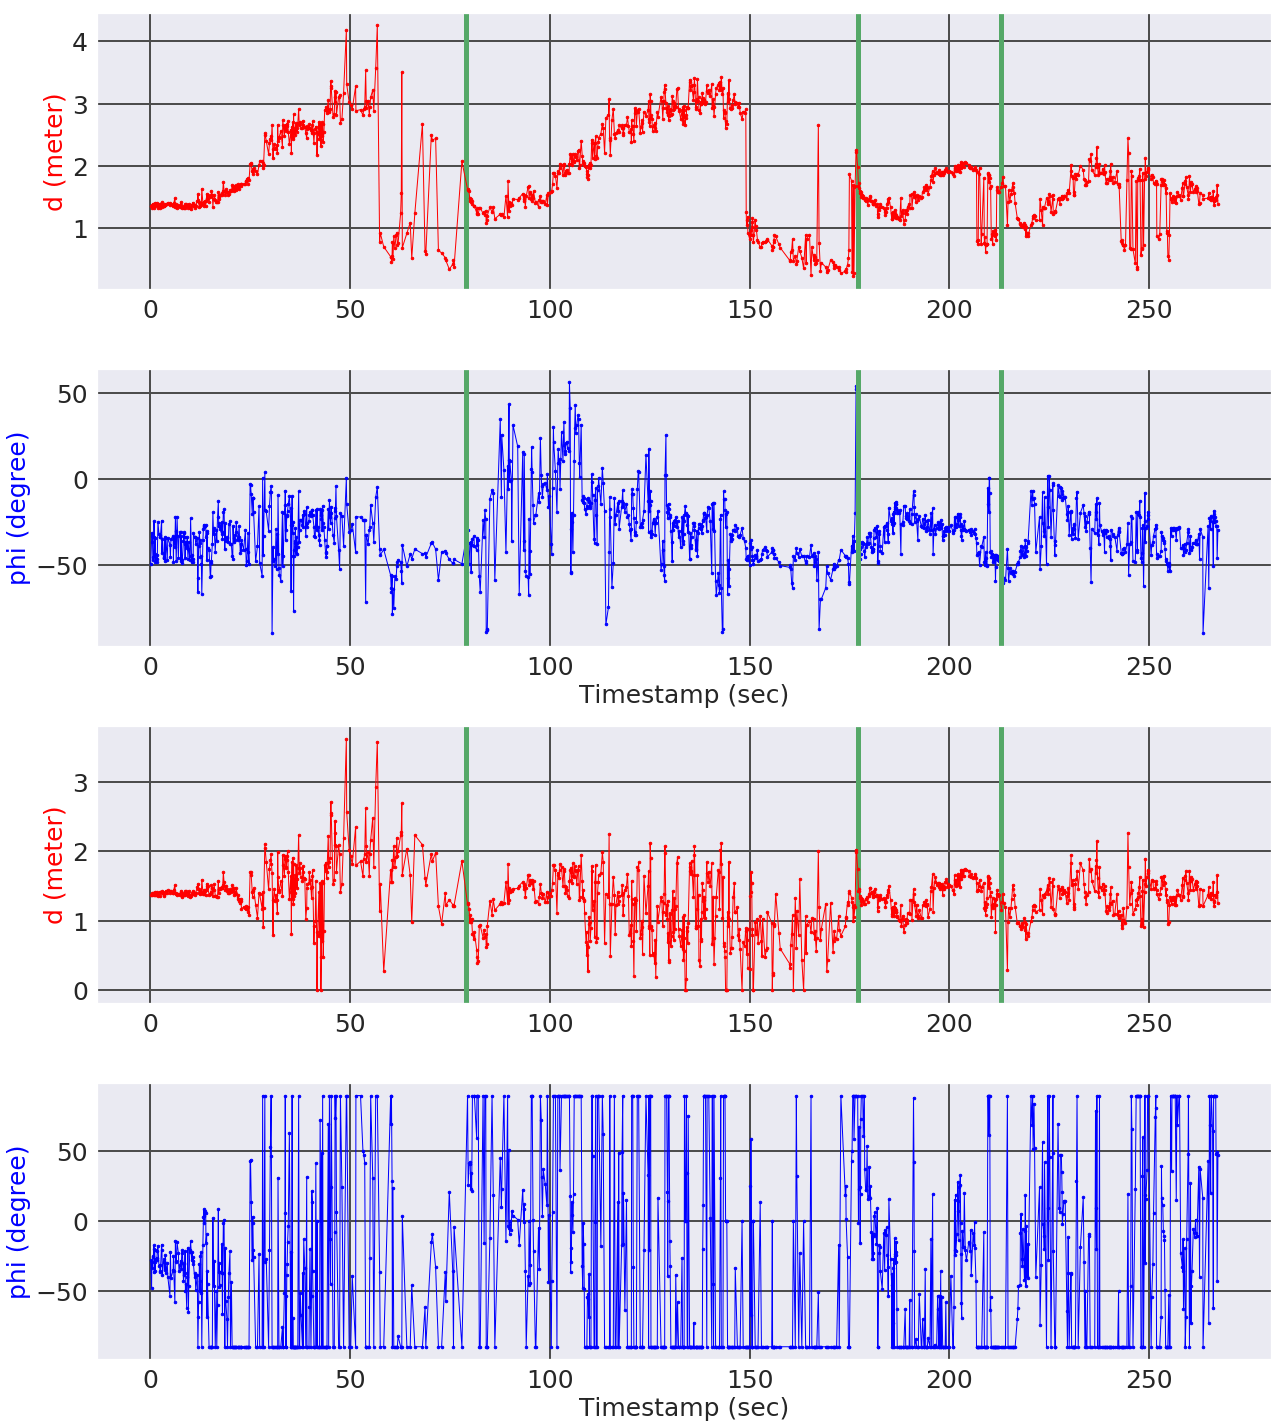

In [94]:

dt_max = 0.1
draw_d_phi = {}

for filename in filenames:

    filename_p = 'data/jackal_ranges_' + filename + '.yaml'
            
    print('New file: ',filename_p)
            
    try:
        with open(filename_p) as dis_file:
            all_data = yaml.load(dis_file)
            r_list = all_data['data']
            timestamps = all_data['timestamp'][guid_path[0]]
            start_time = all_data['start_time']['secs'] + all_data['start_time']['nsecs']*1e-9

            joints = all_data['joint']
            joint_stamps = all_data['joint_stamp']
            
            del all_data
    except IOError:
        print("No such file", filename)
        continue
    
    f, axes = plt.subplots(nrows = 4, ncols = 1, figsize=(18,20))
    guid_sec = 0
    mds_r_key = ['bb', 'bf', 'fb', 'ff']
    mds_r = {}
    for k in mds_r_key:
        mds_r[k] = {}
        mds_r[k]['r'] = None
        mds_r[k]['t'] = None
    mds_flag = False
    joint = None
    anc_len = None
    draw_d_phi[filename] = None
    anchor_stamp = np.array([])
    
    # truncate useless rosbag
    end_t = timestamps[-1]
    if filename == '0112_1153':
        end_t = 490.
    
    for i in range(len(timestamps)):
        
        if timestamps[i] > end_t:
            break
        
        
        # check change anchor
        if guid_sec < len(guid_path)-2:
            if r_list['back_left'][guid_path[guid_sec+2]][i] !=0 or r_list['front_right'][guid_path[guid_sec+2]][i] !=0:
                guid_sec += 1
                mds_r['bb'] = mds_r['bf']
                mds_r['fb'] = mds_r['ff']
                mds_r['bf']['r'] = None
                mds_r['bf']['t'] = None
                mds_r['ff']['r'] = None
                mds_r['ff']['t'] = None
                #print("change", guid_sec)
                anchor_stamp = np.append(anchor_stamp, timestamps[i])
        if guid_sec > 0:
            if r_list['back_left'][guid_path[guid_sec-1]][i] !=0 or r_list['front_right'][guid_path[guid_sec-1]][i] !=0:
                guid_sec -= 1
                mds_r['bf'] = mds_r['bb']
                mds_r['ff'] = mds_r['fb']
                mds_r['bb']['r'] = None
                mds_r['bb']['t'] = None
                mds_r['fb']['r'] = None
                mds_r['fb']['t'] = None
                #print("change", guid_sec)
                anchor_stamp = anchor_stamp[:-1]
        
                
        # check if had range
        this_r = {}
        this_r['bb'] = r_list['back_left'][guid_path[guid_sec]][i]
        this_r['bf'] = r_list['back_left'][guid_path[guid_sec+1]][i]
        this_r['fb'] = r_list['front_right'][guid_path[guid_sec]][i]
        this_r['ff'] = r_list['front_right'][guid_path[guid_sec+1]][i]
        
        # get stick length and height
        joint = joints[np.argmax(joint_stamps > timestamps[i])-1]
        j_ang = joint + math.pi
        dh_b = 0.3 + -0.05 + stick_l * math.cos(j_ang)
        dh_f = 0.5
        r_tag_points[0,0] = -0.14 -(stick_l * math.sin(j_ang))
        
        for k in mds_r_key:
            if this_r[k] != 0:

                if k[0] == 'b': # ranging from robot back tag
                    if this_r[k] * 0.001 > dh_b:
                        mds_r[k]['r'] = math.sqrt((this_r[k] * 0.001)**2 - dh_b**2)
                    else:
                        mds_r[k]['r'] = 0.1 # give a small value if almost arrive
                if k[0] == 'f': # ranging from robot front tag
                    if this_r[k] * 0.001 > dh_f:
                        mds_r[k]['r'] = math.sqrt((this_r[k] * 0.001)**2 - dh_f**2)
                    else:
                        mds_r[k]['r'] = 0.1 # give a small value if almost arrive
                        
                mds_r[k]['r'] = this_r[k] * 0.001
                mds_r[k]['t'] = timestamps[i]
        
        # check if all range is here
        if None not in [mds_r['bb']['r'], mds_r['bf']['r'], mds_r['fb']['r'], mds_r['ff']['r']]:
            mds_flag = True
            anc_len = guid_len[guid_sec]
            
            # check if dt < dt_max
            for k in mds_r_key:
                if timestamps[i] - mds_r[k]['t'] > dt_max:
                    mds_r[k]['r'] = None
                    mds_r[k]['t'] = None
                    mds_flag = False
        
        if mds_flag:
            
            ### mds #######
            r_matrix = np.array([[0, np.linalg.norm(r_tag_points[0]-r_tag_points[1])],
                        [np.linalg.norm(r_tag_points[0]-r_tag_points[1]), 0]])
            
            this_rb = [mds_r['bb']['r'], mds_r['fb']['r']]
            this_rf = [mds_r['bf']['r'], mds_r['ff']['r']]
            r_matrix = np.vstack((r_matrix, this_rb))
            r_matrix = np.vstack((r_matrix, this_rf))
            this_rb = np.append(this_rb, [0, anc_len])
            this_rf = np.append(this_rf, [anc_len, 0])
            r_matrix = np.hstack((r_matrix, np.resize(this_rb, (len(this_rb),1))))
            r_matrix = np.hstack((r_matrix, np.resize(this_rf, (len(this_rb),1))))

            model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
            # print(r_matrix)
            out = model.fit_transform(r_matrix)
            
            # Transform the output points
            def transform(bp, fp):
                last_pos = self.tag_pos[self.id_to_anc[self.last_tag]]
                next_pos = self.tag_pos[self.id_to_anc[self.next_tag]]
                v_anc = np.array(next_pos) - np.array(last_pos)
                ang_anc = math.atan2(v_anc[1], v_anc[0])
                v = fp-bp
                ang = math.atan2(v[1],v[0])
                d_ang = ang - ang_anc
                TM_pre = np.array([[1, 0, -last_pos[0]],
                            [0, 1, -last_pos[1]],
                            [0, 0, 1]])
                TM = np.array([[math.cos(d_ang),-math.sin(d_ang),bp[0]],
                            [math.sin(d_ang),math.cos(d_ang),bp[1]],
                            [0, 0, 1]])
                TM = np.linalg.inv(np.dot(TM, TM_pre))
                # print TM
                return TM
            def transform_r(bp, fp):
                v = fp-bp
                vo = np.array(r_tag_points[1]) - np.array(r_tag_points[0])
                ang = math.atan2(v[1],v[0]) - math.atan2(vo[1],vo[0])
                TM = np.array([[math.cos(ang),-math.sin(ang),bp[0]],
                            [math.sin(ang),math.cos(ang),bp[1]],
                            [0, 0, 1]])
                TM = np.linalg.inv(TM)
                # print TM
                return TM

            # Check if the MDS results is flipped
            # Very Important!!!!!!!
            flip = check_flip(out, True)
            if flip:
                out[:, 0] = -1*out[:, 0]

            #if self.anchor_frame == 'base_link':
            #    TM = transform_r(out[-4],out[-3]) # out[-4]: robot back_left, out[-3]: robot front_right
            #else:
            #    TM = transform(out[-2],out[-1]) # out[-2]: anchor back, out[-1]: anchor front
            
            TM = transform_r(out[-4],out[-3])
            out_modified = np.dot(TM[:2, :2], out[-4:][-4:].T).T + TM[:2,2]
            # print(out_modified)
            out_modified[:,0] = out_modified[:,0] + r_tag_points[0,0]
            # print(out_modified)

            ## d and phi
            x2 = out_modified[-1][0]
            x1 = out_modified[-2][0]
            y2 = out_modified[-1][1]
            y1 = out_modified[-2][1]
            line = np.polyfit([x2, x1], [y2, y1], 1)
            d = math.fabs(line[1]) / np.linalg.norm([line[0], -1])
            phi = math.atan2((y2-y1), (x2-x1)) * -1
            
            #print(timestamps[i], d, math.degrees(phi))
            ################
            
            ### geography #######
            
            s1 = (mds_r['ff']['r'] + mds_r['fb']['r'] + anc_len)/2
            if s1 < anc_len or s1 < mds_r['ff']['r'] or s1 < mds_r['fb']['r']:
                d1 = 0
            else:
                d1 = 2*math.sqrt(s1*(s1-mds_r['ff']['r'])*(s1-mds_r['fb']['r'])*(s1-anc_len))/anc_len
            s2 = (mds_r['bf']['r'] + mds_r['bb']['r'] + anc_len)/2
            if s2 < anc_len or s2 < mds_r['bf']['r'] or s2 < mds_r['bb']['r']:
                d2 = 0
            else:
                d2 = 2*math.sqrt(s2*(s2-mds_r['bf']['r'])*(s2-mds_r['bb']['r'])*(s2-anc_len))/anc_len

            # get d, phi relative to the lane
            d_g = (d1+d2)/2
            sin_v = (d1-d2)/np.linalg.norm(r_tag_points[0]-r_tag_points[1])
            if sin_v > 1:
                sin_v = 1
            if sin_v < -1:
                sin_v = -1
            phi_g = math.asin(sin_v)
            heading = (mds_r['fb']['r']+mds_r['bf']['r'])-(mds_r['ff']['r']-mds_r['bb']['r'])
            if heading < 0: # the robot is heading back
                phi_g = math.pi - phi_g
                if phi_g > math.pi:
                    phi_g -= 2*math.pi
            #######################
            
            if draw_d_phi[filename] is None:
                draw_d_phi[filename] = {}
                draw_d_phi[filename]['t'] = np.array([])
                draw_d_phi[filename]['d'] = np.array([])
                draw_d_phi[filename]['phi'] = np.array([])
                draw_d_phi[filename]['d_g'] = np.array([])
                draw_d_phi[filename]['phi_g'] = np.array([])
            
            if d < 10 and d_g < 10 and -90 <= math.degrees(phi) <=90 and -90 <= math.degrees(phi) <=90:
                draw_d_phi[filename]['t'] = np.append(draw_d_phi[filename]['t'], timestamps[i])
                draw_d_phi[filename]['d'] = np.append(draw_d_phi[filename]['d'], d)
                draw_d_phi[filename]['phi'] = np.append(draw_d_phi[filename]['phi'], math.degrees(phi))
                draw_d_phi[filename]['d_g'] = np.append(draw_d_phi[filename]['d_g'], d_g)
                draw_d_phi[filename]['phi_g'] = np.append(draw_d_phi[filename]['phi_g'], math.degrees(phi_g))
            
            # initialize
            for k in mds_r_key:
                mds_r[k] = {}
                mds_r[k]['r'] = None
                mds_r[k]['t'] = None
            mds_flag = False
            joint = None
            anc_len = None
    
    for st in anchor_stamp:
        axes[0].axvline(st, linewidth=5, color='g')
    axes[0].plot(draw_d_phi[filename]['t'], draw_d_phi[filename]['d'], color=[1, 0, 0], marker='.', linewidth=1, markersize=5)
    axes[0] = ax_init_d(axes[0], [1, 0, 0])
    for st in anchor_stamp:
        axes[1].axvline(st, linewidth=5, color='g')
    axes[1] = ax_init_phi(axes[1], [0, 0, 1])
    axes[1].plot(draw_d_phi[filename]['t'], draw_d_phi[filename]['phi'], color=[0, 0, 1], marker='.', linewidth=1, markersize=5)
    
    
    for st in anchor_stamp:
        axes[2].axvline(st, linewidth=5, color='g')
    axes[2].plot(draw_d_phi[filename]['t'], draw_d_phi[filename]['d_g'], color=[1, 0, 0], marker='.', linewidth=1, markersize=5)
    axes[2] = ax_init_d(axes[2], [1, 0, 0])
    for st in anchor_stamp:
        axes[1].axvline(st, linewidth=5, color='g')
    axes[3] = ax_init_phi(axes[3], [0, 0, 1])
    axes[3].plot(draw_d_phi[filename]['t'], draw_d_phi[filename]['phi_g'], color=[0, 0, 1], marker='.', linewidth=1, markersize=5)
    
            
    del r_list
    del timestamps
    del joints
    del joint_stamps
    
    f.tight_layout()
    plt.show()
    print "=================================================="

    